In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize
from scipy import integrate

### For $\ell=0$ the initial condition $\phi_{0}$ doesn't change, it's $\phi_{0} = 1$,so the parameters to estimate will be $\epsilon$ and $m_{a}$

In [2]:
##Values
####
eps_ = 2.5e-4#
m_a_ = 1.0e-22#eV/c^2
#r_num = vecRp_data[-1]*eps*m_a/6.39e-27
####
##Integration values
###
x0_0 = 3.#first integration
x0_0v1 = 0.01# Start of integration. Use 0.01 for continuity in l=3 solution, for 0,1,2 0.0 it's ok
xf_0v1 = 10. # End of integration
step_0 = 0.5
##l=0
u1_0 = 0.63173215# 1st trial value of unknown init. cond.
u2_0 = 1.28125868# 2nd trial value of unknown init. cond.
u_0 = np.array([u1_0, u2_0])

In [3]:
def Integrate(func,x0,y0,x,h):
    # Finds value of y for a given x using step size h 
    # and initial value y0 at x0.
    def RK4(func,x0,y0,h):
        K0 = h*func(x0,y0)
        K1 = h*func(x0 + 0.5*h, y0 + 0.5*K0)
        K2 = h*func(x0 + 0.5*h, y0 + 0.5*K1)
        K3 = h*func(x0 + h, y0 + K2)
        return (K0 + 2.*K1 + 2.*K2 + K3)/6.
    X = []
    Y = []
    X.append(x0)
    Y.append(y0)
    while x0 < x:
         # Count number of iterations using step size or
        h = min(h,x - x0)# step height h
        y0 = y0 + RK4(func,x0,y0,h)#update next value of y
        x0 = x0 + h#update next value of x
        X.append(x0)
        Y.append(y0)
    return np.array(X),np.array(Y)

In [4]:
def shooting(func,u,x0,x,xf,step,k,h=0.01):
    def res(u):# Boundary condition residual
        X,Y = Integrate(func,x0,IC(u,k),x,h)
        y = Y[len(Y) - 1]#last value of Y
        r = np.zeros(len(u))
        r[0] = y[0]#y0(inf)=0
        r[1] = y[2]/x + y[3]#y_3(inf)/r + y_4(inf)=0
        return r
    x_list = []
    root_list = []
    while x<=xf:
        #print("x=",x)
        x_list.append(x)
        #print("u=",u)
        root = optimize.root(res,u)
        #print("root=",root)
        u = root.x
        #print("u=",u)
        root_temp = optimize.root(res,root.x)
        #print("root_temp=",root_temp)
        root_list.append(root_temp.x)
        X,Y = Integrate(func,x0,IC(root_temp.x,k),x,h)
        x = x+step
    return X,Y,root_temp,np.array(x_list),np.array(root_list)

In [5]:
def IC(u,k):#Initial conditions array, the first correspond to the initial condition in phi
    return np.array([k,0.0,u[0],0.0,u[1]])

In [6]:
def f0(x,y):
    l = 0.
    F = np.zeros(5)
    if x==0:
        F[0] = y[1]
        F[1] = 2.*y[0]*(y[2]-y[4])
        F[2] = y[3]
        F[3] = 0.
        F[4] = 0.
    else:
        F[0] = y[1]
        F[1] = -2.*(l+1.)*y[1]/x +2.*y[0]*(y[2]-y[4])
        F[2] = y[3]
        F[3] = (2.*l+1.)*x**(2.*l)*y[0]**2. - 2.*y[3]/x
        F[4] = 0.
    return F

In [7]:
def Mass_func(r,phi,l):
    Int = np.zeros(len(r))
    dr = np.diff(r)[0]
    phi_array = np.array(phi[:,0])
    for i in range(0,len(r)-1):
        Int[i+1] = dr*(phi_array[i+1]**2.*r[i+1]**(2.*l+2.)) + Int[i]
    return Int

In [8]:
def Vc2_cir(r,eps,M):
    units =8.95e10*eps**2.
    return (units*M)/r
####
##Units for r in kpc
###
def r_units(r,eps,m_a):
    return (6.39e-27*r)/(eps*m_a)

In [9]:
X0_f,Y0_f,root0_f,arr_x0,arr_list0=shooting(f0,u_0,x0_0v1,x0_0,xf_0v1,step_0,k=1.)

In [10]:
M_r0 = Mass_func(X0_f,Y0_f,l=0.)
Vc2_r0 = Vc2_cir(X0_f,eps_,M_r0)
X0_units = r_units(X0_f,eps_,m_a_)

Text(0.5, 1.0, 'Circular speed')

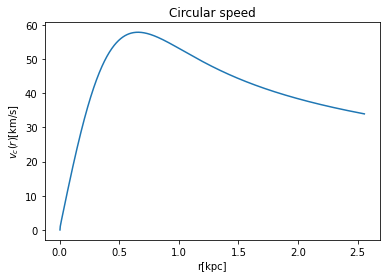

In [11]:
plt.plot(X0_units,np.sqrt(Vc2_r0))
plt.ylabel(r'$v_{c}(r)$[km/s]')
plt.xlabel("r[kpc]")
plt.title('Circular speed')

Text(0.5, 1.0, 'Mass function')

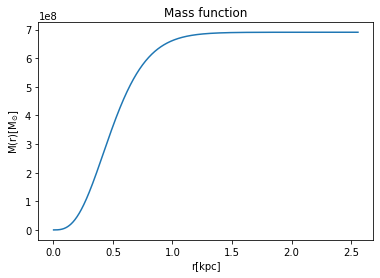

In [12]:
plt.plot(X0_units,M_r0*eps_*1.34e-10/m_a_)
plt.ylabel(r'M(r)[M$_{\odot}]$')
plt.xlabel("r[kpc]")
plt.title('Mass function')

# with r[kpc] from the data

In [13]:
path = "/Users/atalianb/Documents/data_LBSG/LSBG/LSBG/"
data = np.loadtxt(path+"F563-V2_rotmod.dat")

In [14]:
vecRp_data = np.array([row[0] for row in data])# galactocentric distance [kpc]
vecvRp_data = np.array([row[1] for row in data])# rotation velocity [km/s]
vecerrvRp_data = np.array([row[2] for row in data])# error in rotation velocity [km/s]

Text(0.5, 0, 'r[kpc]')

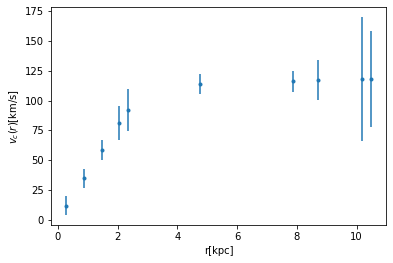

In [15]:
plt.errorbar(vecRp_data,vecvRp_data,yerr=vecerrvRp_data,fmt='.')
plt.ylabel(r'$v_{c}(r)$[km/s]')
plt.xlabel("r[kpc]")

# Pegado de solución

In [16]:
M_r0_units = M_r0*eps_*1.34e-10/m_a_

In [17]:
G_kpc = 4.302e-6#kpc/SolarMass(km/s)^2

In [18]:
if X0_units[-1]<vecRp_data[-1]:
    r_array = np.linspace(X0_units[-1],vecRp_data[-1],80)
    Vc2_rmayor = G_kpc*M_r0_units[-1]/r_array
    Vc2_total = np.append(Vc2_r0,Vc2_rmayor)
    r_total = np.append(X0_units,r_array)

Text(0.5, 0, 'r[kpc]')

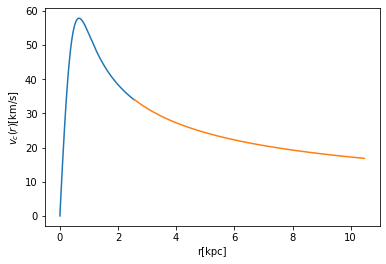

In [20]:
plt.plot(X0_units,np.sqrt(Vc2_r0))
plt.plot(r_array,np.sqrt(Vc2_rmayor))
#plt.plot(r_total,np.sqrt(Vc2_total))
plt.ylabel(r'$v_{c}(r)$[km/s]')
plt.xlabel("r[kpc]")

Now, as a function

In [21]:
def Vc_xy(r,m_a,eps,l=0.):
    X0,Y0,root0_f,arr_x0,arr_list0=shooting(f0,u_0,x0_0v1,x0_0,xf_0v1,step_0,k=1.)
    M_r0 = Mass_func(X0,Y0,l=0.)
    Vc2_r0 = Vc2_cir(X0,eps,M_r0)
    X0_units = r_units(X0,eps,m_a)
    M_r0_units = M_r0*eps*1.34e-10/m_a
    if X0_units[-1]<r[-1]:
        r_array = np.linspace(X0_units[-1],vecRp_data[-1],80)
        Vc2_rmayor = G_kpc*M_r0_units[-1]/r_array
        Vc2_total = np.append(Vc2_r0,Vc2_rmayor)
        r_total = np.append(X0_units,r_array)
        return r_total,np.sqrt(Vc2_total)
    else:
        return X0_units,np.sqrt(Vc2_r0)

In [22]:
Vc_test = Vc_xy(vecRp_data,m_a_,eps_)

Text(0.5, 0, 'r[kpc]')

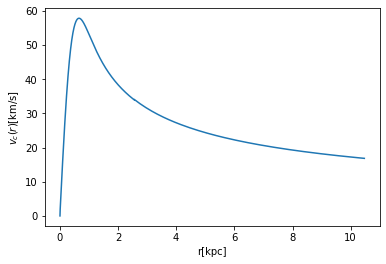

In [23]:
plt.plot(Vc_test[0],Vc_test[1])
plt.ylabel(r'$v_{c}(r)$[km/s]')
plt.xlabel("r[kpc]")

# Interpolation $V_{c,Theory}(r_{i}^{obs})$

In [24]:
from scipy import interpolate

In [25]:
Vc_test[0][-1],vecRp_data[-1]

(10.47, 10.47)

In [26]:
f = interpolate.interp1d(Vc_test[0],Vc_test[1])#,fill_value='extrapolate')
Vc_new = f(vecRp_data)

Text(0.5, 0, 'r[kpc]')

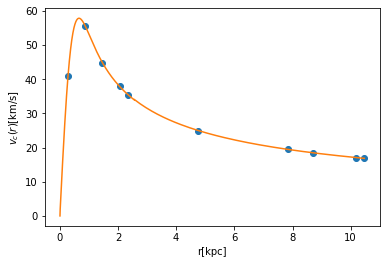

In [27]:
plt.plot(vecRp_data,Vc_new,'o')
plt.plot(Vc_test[0],Vc_test[1])
#plt.errorbar(vecRp_data,vecvRp_data,yerr=vecerrvRp_data,fmt='.')
plt.ylabel(r'$v_{c}(r)$[km/s]')
plt.xlabel("r[kpc]")

As a function

In [28]:
def Vc_xi2(r,m_a,eps,l=0.):
    Vc = Vc_xy(r,m_a,eps)
    f = interpolate.interp1d(Vc[0],Vc[1],fill_value='extrapolate')
    Vc_new = f(r)
    return Vc_new

Text(0.5, 0, 'r[kpc]')

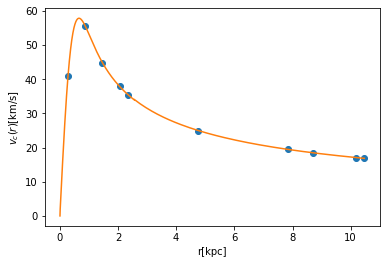

In [29]:
plt.plot(vecRp_data,Vc_xi2(vecRp_data,m_a_,eps_),'o')
plt.plot(Vc_test[0],Vc_test[1])
plt.ylabel(r'$v_{c}(r)$[km/s]')
plt.xlabel("r[kpc]")

# $\chi^{2}$

In [30]:
def Chi2_eps(parameter):
    eps = np.exp(parameter)
    model = Vc_xi2(vecRp_data,m_a_,eps,l=0.)
    xi = np.sum((vecvRp_data-model)**2./(vecerrvRp_data)**2.)
    return xi

In [31]:
x0_eps = np.array(np.log(1.0e-4))
LS_eps = optimize.minimize(Chi2_eps,x0_eps,method='L-BFGS-B',bounds=((np.log(1.0e-6),np.log(1.0e-3)),))
print(LS_eps)

      fun: 316.9634165617035
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.00281375])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 20
      nit: 7
     njev: 10
   status: 0
  success: True
        x: array([-8.32070739])


In [32]:
print(np.exp(LS_eps.x))

[0.00024342]


/Users/atalianb/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  


Text(0.5, 0, 'r[kpc]')

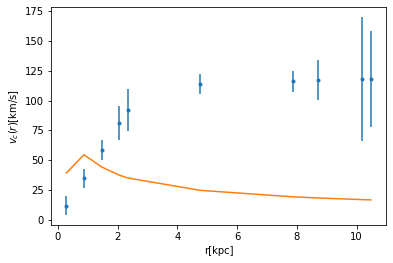

In [33]:
plt.errorbar(vecRp_data,vecvRp_data,yerr=vecerrvRp_data,fmt='.')
plt.plot(vecRp_data,Vc_xi2(vecRp_data,m_a_,np.asscalar(np.exp(LS_eps.x))))
plt.ylabel(r'$v_{c}(r)$[km/s]')
plt.xlabel("r[kpc]")

In [34]:
Vc_eps_sol = Vc_xy(vecRp_data,m_a_,np.asscalar(np.exp(LS_eps.x)),l=0.)

/Users/atalianb/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  """Entry point for launching an IPython kernel.


Text(0.5, 0, 'r[kpc]')

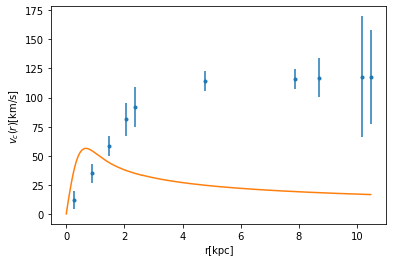

In [35]:
plt.errorbar(vecRp_data,vecvRp_data,yerr=vecerrvRp_data,fmt='.')
plt.plot(Vc_eps_sol[0],Vc_eps_sol[1])
plt.ylabel(r'$v_{c}(r)$[km/s]')
plt.xlabel("r[kpc]")

$m_{a}$

In [36]:
def Chi2_m_a(parameter):
    m_a = np.exp(parameter)
    model = Vc_xi2(vecRp_data,m_a,eps_,l=0.)
    xi = np.sum((vecvRp_data-model)**2./(vecerrvRp_data)**2.)
    return xi

In [38]:
x0_m_a = np.array(np.log(1.0e-23))
LS_m_a = optimize.minimize(Chi2_m_a,x0_m_a,method='L-BFGS-B',bounds=((np.log(1.0e-24),np.log(1.0e-20)),))
print(LS_m_a)

      fun: 147.4232240651213
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.06502034])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 90
      nit: 8
     njev: 45
   status: 0
  success: True
        x: array([-52.64516796])


In [39]:
print(np.exp(LS_m_a.x))

[1.36928564e-23]


/Users/atalianb/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  


Text(0.5, 0, 'r[kpc]')

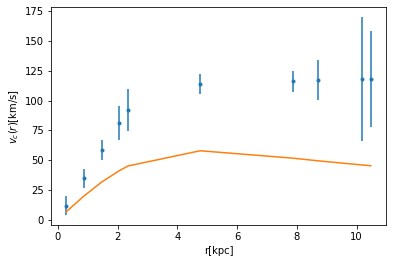

In [40]:
plt.errorbar(vecRp_data,vecvRp_data,yerr=vecerrvRp_data,fmt='.')
plt.plot(vecRp_data,Vc_xi2(vecRp_data,np.asscalar(np.exp(LS_m_a.x)),eps_))
plt.ylabel(r'$v_{c}(r)$[km/s]')
plt.xlabel("r[kpc]")

In [41]:
Vc_m_a_sol = Vc_xy(vecRp_data,np.asscalar(np.exp(LS_m_a.x)),eps_,l=0.)

/Users/atalianb/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  """Entry point for launching an IPython kernel.


<ErrorbarContainer object of 3 artists>

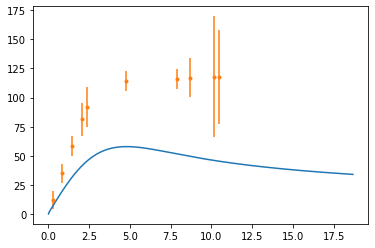

In [42]:
plt.plot(Vc_m_a_sol[0],Vc_m_a_sol[1])
plt.errorbar(vecRp_data,vecvRp_data,yerr=vecerrvRp_data,fmt='.')

/Users/atalianb/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  """Entry point for launching an IPython kernel.


Text(0.5, 0, 'r[kpc]')

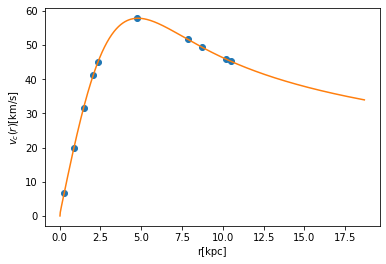

In [43]:
plt.plot(vecRp_data,Vc_xi2(vecRp_data,np.asscalar(np.exp(LS_m_a.x)),eps_),'o')
plt.plot(Vc_m_a_sol[0],Vc_m_a_sol[1])
plt.ylabel(r'$v_{c}(r)$[km/s]')
plt.xlabel("r[kpc]")

# Two parameters

$m_{a}$ y $\epsilon$

In [44]:
def Vc_l0_m_a_eps(r,params):
    m_a,eps = params
    return Vc_xi2(r,m_a,eps,l=0.)

In [45]:
def Xi2_m_a_eps(params):
    m_a,eps = params
    par = np.exp(m_a),np.exp(eps)
    model = Vc_l0_m_a_eps(vecRp_data,par)
    xi  = np.sum((vecvRp_data-model)**2./(vecerrvRp_data)**2.)
    return xi

In [46]:
x0_m_a_eps = np.array([np.log(1.0e-23),np.log(1.0e-4)])
LS_m_a_eps = optimize.minimize(Xi2_m_a_eps,x0_m_a_eps,method='L-BFGS-B',bounds=((np.log(1.0e-24),np.log(1.0e-20)),(np.log(1.0e-5),np.log(1.)),))
print(LS_m_a_eps)

      fun: 1.086277067002097
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([8.88178346e-07, 1.48769886e-06])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 42
      nit: 11
     njev: 14
   status: 0
  success: True
        x: array([-53.55840089,  -7.55082372])


In [47]:
print(np.exp(LS_m_a_eps.x))

[5.49391626e-24 5.25676941e-04]


/Users/atalianb/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  


Text(0.5, 0, 'r[kpc]')

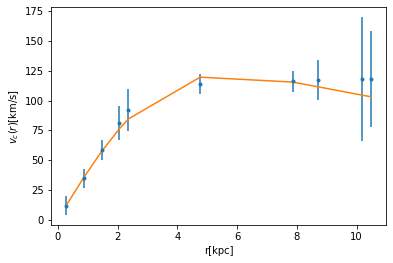

In [48]:
plt.errorbar(vecRp_data,vecvRp_data,yerr=vecerrvRp_data,fmt='.')
plt.plot(vecRp_data,Vc_xi2(vecRp_data,np.asscalar(np.exp(LS_m_a_eps.x[0])),np.asscalar(np.exp(LS_m_a_eps.x[1]))))
plt.ylabel(r'$v_{c}(r)$[km/s]')
plt.xlabel("r[kpc]")

In [50]:
Vc_eps_m_a_sol = Vc_xy(vecRp_data,np.asscalar(np.exp(LS_m_a_eps.x[0])),np.asscalar(np.exp(LS_m_a_eps.x[1])))

/Users/atalianb/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  """Entry point for launching an IPython kernel.


(0.0, 11.0)

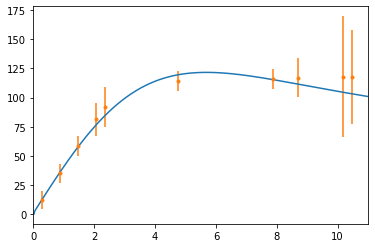

In [51]:
plt.plot(Vc_eps_m_a_sol[0],Vc_eps_m_a_sol[1])
plt.errorbar(vecRp_data,vecvRp_data,yerr=vecerrvRp_data,fmt='.')
plt.xlim(0,11)

# Using other datasets

F568-3_rotmod.dat

In [52]:
F568 = np.loadtxt(path+"F568-3_rotmod.dat")

In [53]:
vecRp_F568 = np.array([row[0] for row in F568])# galactocentric distance [kpc]
vecvRp_F568 = np.array([row[1] for row in F568])# rotation velocity [km/s]
vecerrvRp_F568 = np.array([row[2] for row in F568])# error in rotation velocity [km/s]

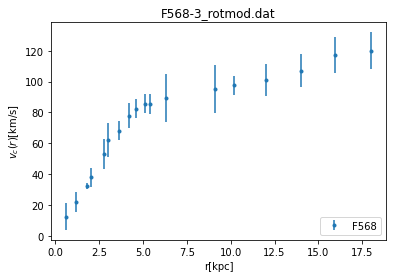

In [54]:
plt.errorbar(vecRp_F568,vecvRp_F568,yerr=vecerrvRp_F568,fmt='.',label='F568')
plt.ylabel(r'$v_{c}(r)$[km/s]')
plt.xlabel("r[kpc]")
plt.title('F568-3_rotmod.dat')
plt.legend(loc='lower right', prop={'size':10})

In [55]:
def Chi2_eps_F568(parameter):
    eps = np.exp(parameter)
    model = Vc_xi2(vecRp_F568,m_a_,eps,l=0.)
    xi = np.sum((vecvRp_F568-model)**2./(vecerrvRp_F568)**2.)
    return xi

In [56]:
x0_eps_F568 = np.array(np.log(1.0e-4))
LS_eps_F568 = optimize.minimize(Chi2_eps_F568,x0_eps_F568,method='L-BFGS-B',bounds=((np.log(1.0e-6),np.log(1.0e-3)),))
print(LS_eps_F568)

      fun: 947.5816207540938
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([0.05794618])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 24
      nit: 8
     njev: 12
   status: 0
  success: True
        x: array([-8.14179107])


In [57]:
print(np.exp(LS_eps_F568.x))

[0.00029112]


/Users/atalianb/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  


Text(0.5, 0, 'r[kpc]')

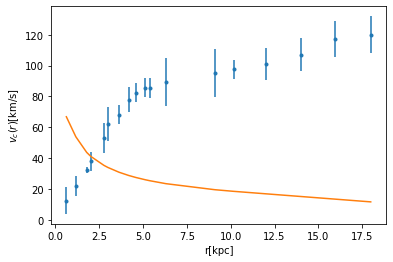

In [58]:
plt.errorbar(vecRp_F568,vecvRp_F568,yerr=vecerrvRp_F568,fmt='.')
plt.plot(vecRp_F568,Vc_xi2(vecRp_F568,m_a_,np.asscalar(np.exp(LS_eps_F568.x))))
plt.ylabel(r'$v_{c}(r)$[km/s]')
plt.xlabel("r[kpc]")

$m_{a}$

In [59]:
def Chi2_m_a_F568(parameter):
    m_a = np.exp(parameter)
    model = Vc_xi2(vecRp_F568,m_a,eps_,l=0.)
    xi = np.sum((vecvRp_F568-model)**2./(vecerrvRp_F568)**2.)
    return xi

In [60]:
x0_m_a_F568 = np.array(np.log(1.0e-23))
LS_m_a_F568 = optimize.minimize(Chi2_m_a_F568,x0_m_a_F568,method='L-BFGS-B',bounds=((np.log(1.0e-24),np.log(1.0e-20)),))
print(LS_m_a_F568)

      fun: 295.94778591439797
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([0.16229363])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 66
      nit: 8
     njev: 33
   status: 0
  success: True
        x: array([-52.9066506])


In [61]:
print(np.exp(LS_m_a_F568.x))

[1.05422568e-23]


/Users/atalianb/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
/Users/atalianb/miniconda3/envs/py37/lib/python3.7/site-packages/scipy/interpolate/interpolate.py:605: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


Text(0.5, 0, 'r[kpc]')

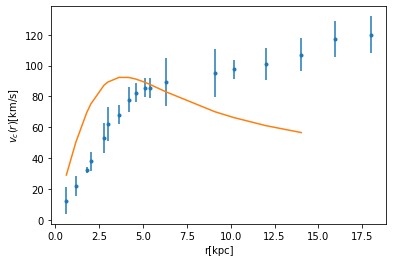

In [62]:
plt.errorbar(vecRp_F568,vecvRp_F568,yerr=vecerrvRp_F568,fmt='.')
plt.plot(vecRp_F568,Vc_xi2(vecRp_F568,np.asscalar(np.exp(LS_m_a_F568.x)),4.0e-4))
plt.ylabel(r'$v_{c}(r)$[km/s]')
plt.xlabel("r[kpc]")

# Dos parámetros

$m_{a}$ y $\epsilon$

In [63]:
def Xi2_m_a_eps_F568(params):
    m_a,eps = params
    par = np.exp(m_a),np.exp(eps)
    model = Vc_l0_m_a_eps(vecRp_F568,par)
    xi  = np.sum((vecvRp_F568-model)**2./(vecerrvRp_F568)**2.)
    return xi

In [64]:
x0_m_a_eps_F568 = np.array([np.log(1.0e-23),np.log(1.0e-5)])
LS_m_a_eps_F568 = optimize.minimize(Xi2_m_a_eps_F568,x0_m_a_eps_F568,method='L-BFGS-B',bounds=((np.log(1.0e-25),np.log(1.0e-21)),(np.log(1.0e-6),np.log(1.0e-3)),))
print(LS_m_a_eps_F568)

      fun: 959.2739818725831
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([2.54568683, 2.71230648])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 186
      nit: 14
     njev: 62
   status: 0
  success: True
        x: array([-49.60066959,  -7.03337794])


In [65]:
print(np.exp(LS_m_a_eps_F568.x))

[2.87543067e-22 8.81947581e-04]


/Users/atalianb/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  


Text(0.5, 0, 'r[kpc]')

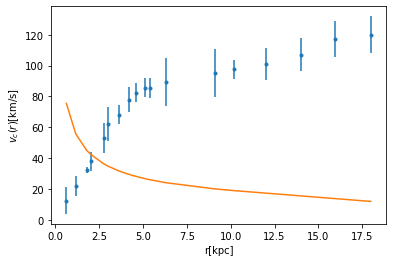

In [66]:
plt.errorbar(vecRp_F568,vecvRp_F568,yerr=vecerrvRp_F568,fmt='.')
plt.plot(vecRp_F568,Vc_xi2(vecRp_F568,np.asscalar(np.exp(LS_m_a_eps_F568.x[0])),np.asscalar(np.exp(LS_m_a_eps_F568.x[1]))))
plt.ylabel(r'$v_{c}(r)$[km/s]')
plt.xlabel("r[kpc]")

# Grid 

In [67]:
ma_array = np.linspace(np.log(1.0e-25),np.log(1.0e-21),10)
eps_array = np.linspace(np.log(1.0e-6),np.log(1.0e-3),10)

In [68]:
Z_F568 = np.zeros((len(ma_array), len(eps_array)))
for i in range(0,len(ma_array)):
    for j in range(0,len(eps_array)):
        parameters = np.array([ma_array[i],eps_array[j]])
        Z_F568[j,i] = Xi2_m_a_eps_F568(parameters)

/Users/atalianb/miniconda3/envs/py37/lib/python3.7/site-packages/scipy/interpolate/interpolate.py:605: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


In [69]:
Ma_grid,Eps_grid = np.meshgrid(ma_array,eps_array)

Text(0.5, 0, '$\\chi$')

/Users/atalianb/miniconda3/envs/py37/lib/python3.7/site-packages/matplotlib/colors.py:1062: RuntimeWarning: invalid value encountered in true_divide
  resdat /= (vmax - vmin)
/Users/atalianb/miniconda3/envs/py37/lib/python3.7/site-packages/mpl_toolkits/mplot3d/proj3d.py:109: RuntimeWarning: invalid value encountered in true_divide
  txs, tys, tzs = vecw[0]/w, vecw[1]/w, vecw[2]/w


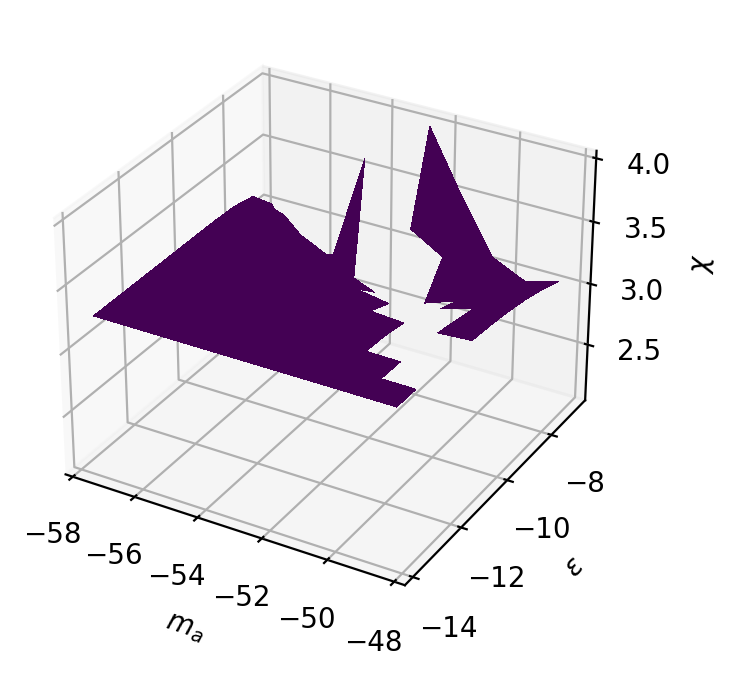

In [70]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"},dpi=200)
# Plot the surface.
surf = ax.plot_surface(Ma_grid,Eps_grid,np.log10(Z_F568),cmap='viridis',linewidth=0,antialiased=False)
ax.set_xlabel(r'$m_{a}$')
ax.set_ylabel(r'$\epsilon$')
ax.set_zlabel(r'$\chi$')

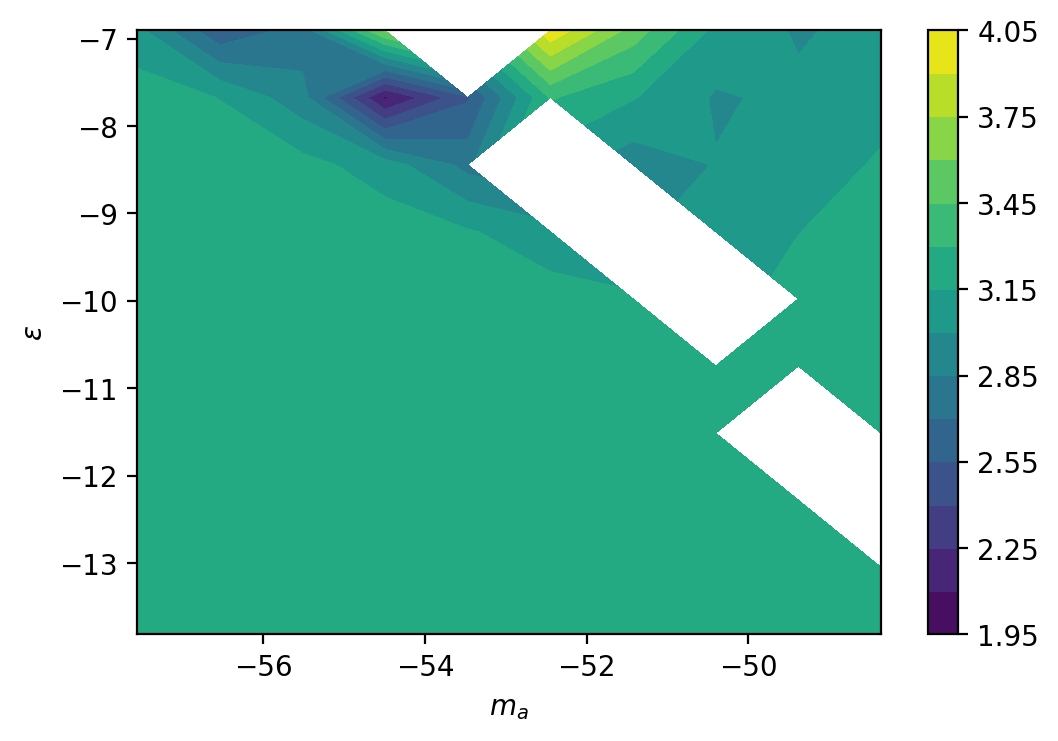

In [71]:
fig = plt.figure(dpi=200)
plt.contourf(Ma_grid,Eps_grid,np.log10(Z_F568),15,cmap='viridis')
plt.xlabel(r'$m_{a}$')
plt.ylabel(r'$\epsilon$')
plt.colorbar();

In [72]:
#limits for m_a
np.exp(-55),np.exp(-53)

(1.2995814250075031e-24, 9.602680054508676e-24)

In [73]:
#limits for epsilon
np.exp(-8),np.exp(-7)

(0.00033546262790251185, 0.0009118819655545162)

In [74]:
x0_m_a_eps_F568 = np.array([np.log(5.0e-24),np.log(5.0e-4)])
LS_m_a_eps_F568 = optimize.minimize(Xi2_m_a_eps_F568,x0_m_a_eps_F568,method='L-BFGS-B',bounds=((np.log(1.0e-24),np.log(1.0e-23)),(np.log(1.0e-4),np.log(9.0e-4)),))
print(LS_m_a_eps_F568)

      fun: 13.552647748128475
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([-3.55271338e-07, -1.59872117e-06])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 42
      nit: 10
     njev: 14
   status: 0
  success: True
        x: array([-54.11977994,  -7.65560676])


In [75]:
print(np.exp(LS_m_a_eps_F568.x))

[3.13385003e-24 4.73382532e-04]


/Users/atalianb/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  


Text(0.5, 0, 'r[kpc]')

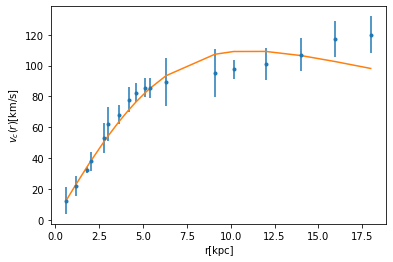

In [76]:
plt.errorbar(vecRp_F568,vecvRp_F568,yerr=vecerrvRp_F568,fmt='.')
plt.plot(vecRp_F568,Vc_xi2(vecRp_F568,np.asscalar(np.exp(LS_m_a_eps_F568.x[0])),np.asscalar(np.exp(LS_m_a_eps_F568.x[1]))))
plt.ylabel(r'$v_{c}(r)$[km/s]')
plt.xlabel("r[kpc]")

F571

In [77]:
F571 = np.loadtxt(path+"F571-V1_rotmod.dat")

In [78]:
vecRp_F571 = np.array([row[0] for row in F571])# galactocentric distance [kpc]
vecvRp_F571 = np.array([row[1] for row in F571])# rotation velocity [km/s]
vecerrvRp_F571 = np.array([row[2] for row in F571])# error in rotation velocity [km/s]

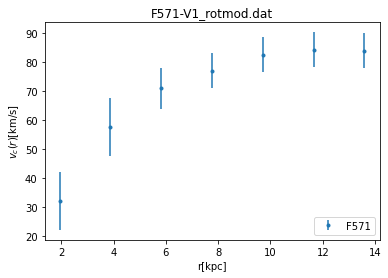

In [79]:
plt.errorbar(vecRp_F571,vecvRp_F571,yerr=vecerrvRp_F571,fmt='.',label='F571')
plt.ylabel(r'$v_{c}(r)$[km/s]')
plt.xlabel("r[kpc]")
plt.title('F571-V1_rotmod.dat')
plt.legend(loc='lower right', prop={'size':10})

# $\epsilon$

In [80]:
def Chi2_eps_F571(parameter):
    eps = np.exp(parameter)
    model = Vc_xi2(vecRp_F571,m_a_,eps,l=0.)
    xi = np.sum((vecvRp_F571-model)**2./(vecerrvRp_F571)**2.)
    return xi

In [81]:
x0_eps_F571 = np.array(np.log(1.0e-4))
LS_eps_F571 = optimize.minimize(Chi2_eps_F571,x0_eps_F571,method='L-BFGS-B',bounds=((np.log(1.0e-5),np.log(1.0e-2)),))
print(LS_eps_F571)

      fun: 192.4575028901836
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([-3.97903934e-05])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 18
      nit: 5
     njev: 9
   status: 0
  success: True
        x: array([-5.91992208])


In [82]:
print(np.exp(LS_eps_F571.x))

[0.00268541]


/Users/atalianb/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  


Text(0.5, 0, 'r[kpc]')

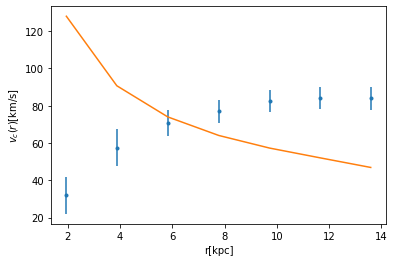

In [83]:
plt.errorbar(vecRp_F571,vecvRp_F571,yerr=vecerrvRp_F571,fmt='.')
plt.plot(vecRp_F571,Vc_xi2(vecRp_F571,m_a_,np.asscalar(np.exp(LS_eps_F571.x))))
plt.ylabel(r'$v_{c}(r)$[km/s]')
plt.xlabel("r[kpc]")

$m_{a}$

In [84]:
def Chi2_m_a_F571(parameter):
    m_a = np.exp(parameter)
    model = Vc_xi2(vecRp_F571,m_a,eps_,l=0.)
    xi = np.sum((vecvRp_F571-model)**2./(vecerrvRp_F571)**2.)
    return xi

In [85]:
x0_m_a_F571 = np.array(np.log(1.0e-23))
LS_m_a_F571 = optimize.minimize(Chi2_m_a_F571,x0_m_a_F571,method='L-BFGS-B',bounds=((np.log(1.0e-24),np.log(1.0e-20)),))
print(LS_m_a_F571)

      fun: 86.01237414852336
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([0.09095799])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 58
      nit: 7
     njev: 29
   status: 0
  success: True
        x: array([-53.33295485])


In [86]:
print(np.exp(LS_m_a_F571.x))

[6.8832256e-24]


/Users/atalianb/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  


Text(0.5, 0, 'r[kpc]')

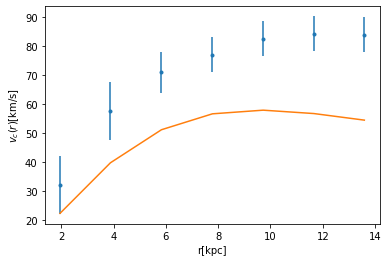

In [87]:
plt.errorbar(vecRp_F571,vecvRp_F571,yerr=vecerrvRp_F571,fmt='.')
plt.plot(vecRp_F571,Vc_xi2(vecRp_F571,np.asscalar(np.exp(LS_m_a_F571.x)),eps_))
plt.ylabel(r'$v_{c}(r)$[km/s]')
plt.xlabel("r[kpc]")

# Dos parámetros

$m_{a}$ y $\epsilon$

In [88]:
def Xi2_m_a_eps_F571(params):
    m_a,eps = params
    par = np.exp(m_a),np.exp(eps)
    model = Vc_l0_m_a_eps(vecRp_F571,par)
    xi  = np.sum((vecvRp_F571-model)**2./(vecerrvRp_F571)**2.)
    return xi

In [92]:
x0_m_a_eps_F571 = np.array([np.log(1.0e-23),np.log(1.0e-4)])
LS_m_a_eps_F571 = optimize.minimize(Xi2_m_a_eps_F571,x0_m_a_eps_F571,method='L-BFGS-B',bounds=((np.log(1.0e-25),np.log(1.0e-20)),(np.log(1.0e-5),np.log(1.0e-3)),))
print(LS_m_a_eps_F571)

/Users/atalianb/miniconda3/envs/py37/lib/python3.7/site-packages/scipy/interpolate/interpolate.py:605: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/Users/atalianb/miniconda3/envs/py37/lib/python3.7/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


      fun: 0.7149116482026654
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([-4.32986944e-07, -2.44249067e-07])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 57
      nit: 11
     njev: 19
   status: 0
  success: True
        x: array([-53.82769318,  -7.91710448])


In [93]:
print(np.exp(LS_m_a_eps_F571.x))

[4.19691217e-24 3.64456090e-04]


/Users/atalianb/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  


Text(0.5, 0, 'r[kpc]')

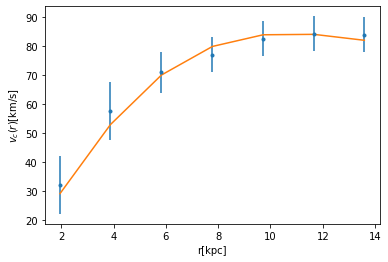

In [94]:
plt.errorbar(vecRp_F571,vecvRp_F571,yerr=vecerrvRp_F571,fmt='.')
plt.plot(vecRp_F571,Vc_xi2(vecRp_F571,np.asscalar(np.exp(LS_m_a_eps_F571.x[0])),np.asscalar(np.exp(LS_m_a_eps_F571.x[1]))))
plt.ylabel(r'$v_{c}(r)$[km/s]')
plt.xlabel("r[kpc]")